# CNN Hyperparameter Tuning with Bayesian Optimization for MNIST Classification

This example demonstrate the usage of Bayesian optimization (BO) as implemented in scikit-optimize for tuning the hyper parameters of a neural network. As compared to grid search or random search less hyper parameter combinations need to be evaluated to determine the near-optimal configuration.

In each iteration of BO the neural network is trained with a different set of hyper parameters and its validation accuracy is computed. A gaussian process is fitted to the validation accuracy over the space of hyper parameters. An acquistion function which is a function of the fitted gaussian process is sampled for the next suitable hyper parameter combination which is expected to increase validation accuracy.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
import numpy as np
import uuid
import os

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
num_classes = 10

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
def create_model(activation, learning_rate, adam_decay, dropout, dense_units, 
                 conv_0_channels, conv_1_channels):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(conv_0_channels, kernel_size=(3, 3),
                  activation=activation,
                  input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(conv_1_channels, (3, 3), activation=activation))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(dense_units, activation=activation))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=learning_rate, decay=adam_decay),
                metrics=['accuracy'])
  
  return model

In [0]:
model = create_model(activation="relu", learning_rate=0.01, adam_decay=0.0, dropout=0.25, dense_units=128, 
                 conv_0_channels=32, conv_1_channels=64)

In [0]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2761435508728027
Test accuracy: 0.6093999743461609


### Baysian Optimization

In [0]:
# mount Google Drive first and enter a path where models are stored
root_path = "drive/My Drive/Colab Notebooks/models"

In [13]:
!pip install scikit-optimize

In [0]:
from skopt import gp_minimize, gbrt_minimize
from skopt.utils import use_named_args, dump
from skopt.space import Real, Categorical, Integer 

In [0]:
# # define the hyper parameter search space
# dim_activation = Categorical(["relu", "tanh", "selu", "elu", "exponential"], name="activation")
# dim_learning_rate = Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate")
# dim_adam_decay = Real(1e-8, 1e-1, prior="log-uniform", name="adam_decay")
# dim_dropout = Real(0.0, 1.0, name="dropout")
# dim_dense_units = Integer(32, 512, prior="log-uniform", base=2, name="dense_units")
# dim_conv_0_channels = Integer(8, 64, prior="log-uniform", base=2, name="conv_0_channels")
# dim_conv_1_channels = Integer(8, 128, prior="log-uniform", base=2, name="conv_1_channels")
# dim_batch_size = Integer(1, 256, prior="log-uniform", base=2, name="batch_size")

# dimensions  = [dim_activation,
#                dim_learning_rate,
#                dim_adam_decay,
#                dim_dropout,
#                dim_dense_units,
#                dim_conv_0_channels,
#                dim_conv_1_channels,
#                dim_batch_size]

# #default_parameters = ["relu", 0.01, 0.0, 0.25, 128, 32, 64, 128]  # this yields already quite a good validation accuracy
# default_parameters = ["tanh", 0.01, 1e-8, 0.0, 64, 16, 32, 128]  # start with a worse configuration to demonstrate BO

In [0]:
# define the hyper parameter search space
dim_activation = Categorical(["relu", "tanh", "selu", "elu", "exponential"], name="activation")
dim_learning_rate = Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate")
dim_adam_decay = Real(1e-8, 1e-1, prior="log-uniform", name="adam_decay")
dim_dropout = Real(0.0, 1.0, name="dropout")
dim_dense_units = Integer(5, 9, prior="uniform", name="dense_units")  # log2
dim_conv_0_channels = Integer(3, 6, prior="uniform", name="conv_0_channels")  # log2
dim_conv_1_channels = Integer(3, 7, prior="uniform", name="conv_1_channels")  # log2
dim_batch_size = Integer(6, 9, prior="uniform", name="batch_size")  # log2

dimensions  = [dim_activation,
               dim_learning_rate,
               dim_adam_decay,
               dim_dropout,
               dim_dense_units,
               dim_conv_0_channels,
               dim_conv_1_channels,
               dim_batch_size]

#default_parameters = ["relu", 0.01, 0.0, 0.25, np.log2(128), np.log2(32), np.log2(64), np.log2(128)]  # this yields already quite a good validation accuracy
default_parameters = ["tanh", 0.01, 1e-8, 0.0, np.log2(64), np.log2(16), np.log2(32), np.log2(128)]  # start with a worse configuration to demonstrate BO

In [0]:
# # draw a sample from the parameter space for debugging
# from skopt.space.space import Space
# space = Space(dimensions)
# space.rvs()

In [0]:
# fit model with default parameters
#model = create_model(*default_parameters[:-1])
#hist = model.fit(x_train, y_train, epochs=8, batch_size=128, validation_data=(x_test, y_test), verbose=1)

In [0]:
# objective function which trains and evaluates the model with a given hyperparameter config 
model_ids = []

@use_named_args(dimensions=dimensions)
def objective(activation, learning_rate, adam_decay, dropout, dense_units, 
              conv_0_channels, conv_1_channels, batch_size):
  
  print(activation, learning_rate, adam_decay, dropout, int(2**dense_units), 
                 int(2**conv_0_channels), int(2**conv_1_channels), int(2**batch_size))

  model = create_model(activation, learning_rate, adam_decay, dropout, int(2**dense_units), 
                 int(2**conv_0_channels), int(2**conv_1_channels))
  
  model_fitted = model.fit(x_train, y_train, epochs=8, batch_size=int(2**batch_size), validation_data=(x_test, y_test), verbose=1)

  accuracy = model_fitted.history["val_accuracy"][-1]

  id = uuid.uuid4()
  model_ids.append(id)
  print("Model {}-- Accuracy: {:.2%}".format(id, accuracy))

  # save weights
  model.save_weights(os.path.join(root_path, 'model-{}'.format(id)) )

  del model
  tf.keras.backend.clear_session()

  return -accuracy

In [32]:
gp_result = gp_minimize(func=objective,
                        dimensions=dimensions,
                        n_calls=12,
                        noise=0.01,
                        n_jobs=-1,
                        kappa=5,
                        x0=default_parameters,
                        random_state=0,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
tanh 0.01 1e-08 0.0 64 16 32 128
Epoch 1/8
469/469 [==============================] - 5s 10ms/step - loss: 0.2177 - accuracy: 0.9339 - val_loss: 0.1588 - val_accuracy: 0.9480
Epoch 2/8
469/469 [==============================] - 4s 9ms/step - loss: 0.1863 - accuracy: 0.9426 - val_loss: 0.2503 - val_accuracy: 0.9192
Epoch 3/8
469/469 [==============================] - 4s 9ms/step - loss: 0.2352 - accuracy: 0.9267 - val_loss: 0.2233 - val_accuracy: 0.9296
Epoch 4/8
469/469 [==============================] - 4s 9ms/step - loss: 0.2214 - accuracy: 0.9325 - val_loss: 0.2351 - val_accuracy: 0.9251
Epoch 5/8
469/469 [==============================] - 4s 9ms/step - loss: 0.2389 - accuracy: 0.9250 - val_loss: 0.1622 - val_accuracy: 0.9494
Epoch 6/8
469/469 [==============================] - 4s 9ms/step - loss: 0.2032 - accuracy: 0.9373 - val_loss: 0.2366 - val_accuracy: 0.9260
Epoch 7/8
469/469 [==============================] - 4s 

In [0]:
dump(gp_result, os.path.join(root_path, "BO_result.pkl"))

In [34]:
gp_result.x

['relu',
 0.0006377300155643865,
 1.3801098575179591e-08,
 0.4417109212488455,
 9,
 4,
 5,
 8]

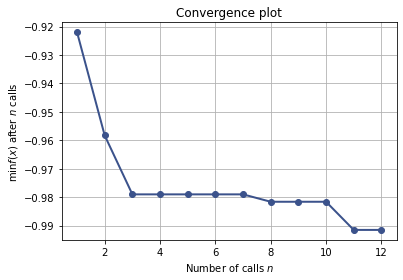

In [35]:
from skopt.plots import plot_convergence
plot_convergence(gp_result)

### Load best model

In [41]:
#best_model_id = "61504fa2-5f6e-4a89-9041-858be90208b7"
best_model_id = model_ids[gp_result.x_iters.index(gp_result.x)]
#model_loaded = create_model(*(gp_result.x[:-1]))

activation = gp_result.x[0]
learning_rate = gp_result.x[1]
adam_decay = gp_result.x[2]
dropout = gp_result.x[3]
dense_units = int(2**gp_result.x[4])
conv_0_channels = int(2**gp_result.x[5])
conv_1_channels = int(2**gp_result.x[6])
model_loaded = create_model(activation, learning_rate, adam_decay, dropout,
                            dense_units, conv_0_channels, conv_1_channels)

model_loaded.load_weights(os.path.join(root_path, "model-{}".format(best_model_id)))

score = model_loaded.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02731534093618393
Test accuracy: 0.9915000200271606


### Retrain the best model

In [0]:
# model_best = create_model(*(gp_result.x[:-1]))
# model_best.fit(x_train, y_train, epochs=8, batch_size=gp_result.x[-1], validation_data=(x_test, y_test), verbose=1)
# score = model_best.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])